# Predicting Match Outcomes from English Premier League Data 2016-2017


In [9]:
''' Basic imports'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
''' Machine learning imports'''
# Feature Importance
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.decomposition import PCA

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

In [7]:
# Cleaned data from R
   
clean_train = pd.read_csv('/Users/Kellen/Desktop/CSUMB SCHTUFF/CST463/EPL_Predictions/CleanPLTrain')

col_names = list(clean_train)

train_y = clean_train['FTR']

clean_train = clean_train.drop(['Unnamed: 0','FTR','Upset',
                                'PredictedOutcome',
                                'UpsetNumeric'], axis=1
                              )

clean_test = pd.read_csv('/Users/Kellen/Desktop/CSUMB SCHTUFF/CST463/EPL_Predictions/CleanPLTest')

test_y = clean_test['FTR']

clean_test = clean_test.drop(['Unnamed: 0','FTR', 'Upset',
                              'PredictedOutcome',
                              'UpsetNumeric'],axis=1
                            )

clean_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138 entries, 0 to 1137
Data columns (total 15 columns):
avgOddsH           1138 non-null float64
avgOddsD           1138 non-null float64
avgOddsA           1138 non-null float64
H_W                1138 non-null int64
A_W                1138 non-null int64
H_D                1138 non-null int64
A_D                1138 non-null int64
H_L                1138 non-null int64
A_L                1138 non-null int64
H_avg_scored       1138 non-null float64
A_avg_scored       1138 non-null float64
H_avg_conceeded    1138 non-null float64
A_avg_conceeded    1138 non-null float64
H_goalDiff         1138 non-null int64
A_goalDiff         1138 non-null int64
dtypes: float64(7), int64(8)
memory usage: 133.4 KB


## Basic Pre-Processing/Scaling

In [8]:
scaler = StandardScaler()
scaled_train_x = scaler.fit_transform(X=clean_train,y=None)

scaled_test_x = scaler.fit_transform(clean_test)

## Principle Component Analysis

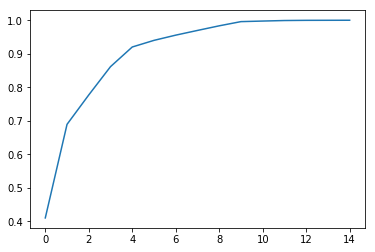

In [11]:
pca = PCA()
pca.fit(scaled_train_x)
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumsum)

### Assign pca values to train and test x's

In [13]:
pca = PCA(n_components = .9)
pca.fit(scaled_train_x)
pca.n_components_

pca_train_x = pca.transform(scaled_train_x)
pca_test_x = pca.transform(scaled_test_x)

## Feature Importance

Feature ranking:
1. feature 10 (0.101042)
2. feature 1 (0.094842)
3. feature 4 (0.085761)
4. feature 6 (0.085560)
5. feature 0 (0.085557)
6. feature 11 (0.084853)
7. feature 7 (0.083343)
8. feature 8 (0.082948)
9. feature 9 (0.081460)
10. feature 2 (0.075347)
11. feature 3 (0.070510)
12. feature 5 (0.068776)


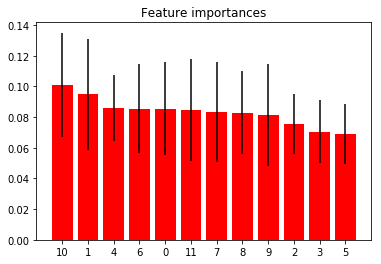

In [18]:
odds_omitted_train_x = scaled_train_x[:,3:]
odds_omitted_test_x = scaled_test_x[:,3:]

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(odds_omitted, train_y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(odds_omitted.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(odds_omitted.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(odds_omitted.shape[1]), indices)
plt.xlim([-1, odds_omitted.shape[1]])
plt.show()

In [17]:
col_names = list(clean_train.drop(['avgOddsH','avgOddsD','avgOddsA'],axis = 1))
for i,name in enumerate(col_names):
    print(str(i) +': ' + name)

0: H_W
1: A_W
2: H_D
3: A_D
4: H_L
5: A_L
6: H_avg_scored
7: A_avg_scored
8: H_avg_conceeded
9: A_avg_conceeded
10: H_goalDiff
11: A_goalDiff


### What does this tell us?
Betting odds are by far and away the best predictors of the outcome of a match. Easily twice as influential as any other feature. 

## Make some quick predictions

In [6]:
print('Blind Prediction Rate: '+ str(round( (sum(train_y == 'H')/len(train_y)) , 2) ) )    

Blind Prediction Rate: 0.45


## Random Forest

In [20]:
train_datasets = [pca_train_x, scaled_train_x, odds_omitted_train_x]
test_datasets = [pca_test_x, scaled_test_x, odds_omitted_test_x]
rf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
for train_x, test_x in zip(train_datasets, test_datasets):
    rf.fit(train_x,train_y)
    #print(train_x)
    print(rf.score(test_x,test_y))

0.5508474576271186
0.5536723163841808
0.5451977401129944


About a 10% Improvement over the base right of predictions.

## KNN with GridSearch

In [21]:
neigh = KNeighborsClassifier()
different_neighbor_counts = range(1,11,2)
param_grid = {'n_neighbors': different_neighbor_counts}

train_datasets = [pca_train_x, scaled_train_x, odds_omitted_train_x]
test_datasets = [pca_test_x, scaled_test_x, odds_omitted_test_x]
for train_x, test_x in zip(train_datasets, test_datasets):
    grid1 = GridSearchCV(neigh, param_grid = param_grid, cv = 5)
    grid1.fit(train_x,train_y)

    print("Best Accuracy: ",grid1.best_score_*100)
    print("Best params: ", grid1.best_params_)

    grid1.score(test_x,test_y)

Best Accuracy:  50.878734622144115
Best params:  {'n_neighbors': 9}
Best Accuracy:  50.527240773286465
Best params:  {'n_neighbors': 7}
Best Accuracy:  51.84534270650264
Best params:  {'n_neighbors': 9}


## Gradient Boost with GridSearch

In [9]:
gbrt = GradientBoostingClassifier()
n_estimators = np.arange(1,20)
depth = np.arange(1,10)
learning_rates = [0.01,0.1,1]

param_grid = {'n_estimators': n_estimators , 'max_depth' : depth, 'learning_rate':learning_rates}

grid1 = GridSearchCV(gbrt, param_grid = param_grid, cv = 5)
grid1.fit(scaled_train_x,train_y.ravel())

print("Best Accuracy: ",grid1.best_score_*100)
print("Best params: ", grid1.best_params_)

grid1.score(scaled_test_x,test_y)

KeyboardInterrupt: 

## Naive Bayes

In [23]:
nb = GaussianNB()
train_datasets = [pca_train_x, scaled_train_x, odds_omitted_train_x]
test_datasets = [pca_test_x, scaled_test_x, odds_omitted_test_x]
for train_x, test_x in zip(train_datasets, test_datasets):
    nb.fit(train_x,train_y)
    print(nb.score(test_x,test_y))

0.5677966101694916
0.5480225988700564
0.5423728813559322
